<H3>PRI 2023/24: second
    project delivery</H3>

**GROUP 1**
- Amanda Tofthagen, 113124
- Tora Kristine Løtveit, 112927
- Tuva Grønvold Natvig, 113107

<H2>Main facilities</H2>

#### Loading and preproccesing data (using with functions made in project 1)

In [1]:
import nltk  
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from collections import defaultdict
from string import punctuation
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from rank_bm25 import BM25Okapi
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.decomposition import PCA
from rank_bm25 import BM25Okapi
from sklearn.preprocessing import normalize


nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1007)>
[nltk_data] Error loading punkt_tab: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1007)>
[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1007)>
[nltk_data] Error loading wordnet: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1007)>


False

In [2]:
# Setup and data preparation 
def preprocess_text(text):
    # Convert text to lower case and tokenize
    tokens = word_tokenize(text.lower())
    # Remove punctuation
    tokens = [token for token in tokens if token not in punctuation]
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    # Lemmatize tokens
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return tokens

# Load metadata as both dataframe and list
def load_metadata(file_path):
    df = pd.read_csv(file_path, low_memory=False)
    df = df[['cord_uid', 'title', 'abstract', 'authors', 'journal']].dropna()  # Keep only required columns
    df['document'] = df.apply(lambda x: f"{x['title']} {x['abstract']} {x['authors']} {x['journal']}", axis=1)
   
    # Store as a list of "title + abstract" for ranking models
    doc_list = df['document'].tolist()
    
    return df, doc_list  # Return both formats
    

# Load qrels
def load_qrels(file_path):  
    qrels = defaultdict(dict)
    with open(file_path, 'r') as f:
        for line in f:
            topic_id, _, doc_id, relevance = line.strip().split()
            qrels[topic_id][doc_id] = int(relevance)
    return qrels

def load_queries(file_path):
    tree = ET.parse(file_path)
    root = tree.getroot()
    queries = {}
    for topic in root.findall('topic'):
        topic_number = topic.get('number')
        query_text = preprocess_text(topic.find('query').text)
        queries[topic_number] = " ".join(query_text)  # Ensure consistency
    return queries

metadata_path = "data2/metadata.csv"
qrels_path = "data2/qrels.txt"
queries_path = "data2/topics.xml"

D, D_list = load_metadata(metadata_path)
qrels = load_qrels(qrels_path)
queries = load_queries(queries_path)

<h3>Part I: clustering</h3>

*A) Clustering*

In [3]:
class BM25Vectorizer:
    """
    Vectorize documents using the BM25 algorithm that convert text data into a numerical
    form that retains textual information in a format suitable for the clustering algorithm 
    """
    def __init__(self, k1=1.5, b=0.75):
        self.k1 = k1
        self.b = b
        # min_df (minimum document frequency) is set to ignore terms that appear too infrequently (in than 1% of the documents)
        # max_df (maximum document frequency) is set to ignore terms that appear too frequently (in more than 50% of the documents)
        self.vectorizer = TfidfVectorizer(tokenizer=self.LemmaTokenizer(), min_df=0.01, max_df=0.5)

    class LemmaTokenizer:
        def __init__(self):
            self.wnl = WordNetLemmatizer()
        def __call__(self, doc):
            return [self.wnl.lemmatize(t) for t in word_tokenize(doc.lower()) if t not in punctuation]

    def transform(self, docs): 
        doc_vectors = []
        for doc in docs:
            doc_tokens = self.vectorizer.build_tokenizer()(doc)
            doc_scores = self.bm25.get_scores(doc_tokens)
            doc_vectors.append(doc_scores)
        return normalize(np.array(doc_vectors), axis=0)

    def fit_transform(self, docs):
        self.terms = self.vectorizer.fit(docs).get_feature_names_out()
        tokenized_docs = [self.vectorizer.build_tokenizer()(doc) for doc in docs]
        self.bm25 = BM25Okapi(tokenized_docs, k1=self.k1, b=self.b)
        vectors = self.transform(docs)  
        return vectors


In [4]:
def determine_number_of_clusters(D, max_k):
    """
    Function to determine the best number of clusters, 
    based on the elbow point and silhouette score
    """
    # First step: Use elbow method to narrow down the range of potential values for k
    distortions = []
    for k in range(1, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(D)
        distortions.append(kmeans.inertia_)
    
    accelerations = np.diff(distortions, 2) # Compute second derivative (accelerations)
    elbow_point = np.argmin(accelerations) # find the "elbow" by looking at the second derivative of the distortions list 

    # Second step: Calculate silhouette scores for values up to the elbow point
    k_range = range(2, elbow_point + 1) 
    silhouette_scores = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(D)
        score = silhouette_score(D, labels)
        silhouette_scores.append(score)
    

    # Select the best k based on the highest silhouette score
    best_k = k_range[np.argmax(silhouette_scores)]
    return best_k

/Users/amandatofthagen/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[{'centroid': array([0.06631613, 0.04815744, 0.0681887 , 0.05485024, 0.05480798,
       0.0532007 , 0.06798235, 0.06824556, 0.05025663, 0.04787436,
       0.05274642, 0.06358274, 0.05649843, 0.05473724, 0.05868211,
       0.06409319, 0.06414601, 0.06652891, 0.06790416, 0.06815638,
       0.05192067, 0.04809944, 0.05969584, 0.0683008 , 0.06374919,
       0.0690675 , 0.06673047, 0.06540228, 0.05516024, 0.0649144 ,
       0.0524518 , 0.04686105, 0.06190761, 0.05481743, 0.05374882,
       0.05571603, 0.06274598, 0.06530634, 0.06660713, 0.06709904,
       0.06908371, 0.0650973 , 0.04933752, 0.06787921, 0.06587019,
       0.06501897, 0.06402471, 0.05459786, 0.06796773, 0.06972024,
       0.06646925, 0.06707058, 0.0660323 , 0.06670304, 0.055267  ,
       0.06904103, 0.0665812 , 0.01816785, 0.06546858, 0.04718897,
       0.06316063, 0.06660001, 0.04942565, 0.06594966, 0.06774339,
       0.06370673, 0.06669334, 0.05471778, 0.05710848, 0.05175787,
       0.06138134, 0.04411134, 0.0480951 , 0.065

/Users/amandatofthagen/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


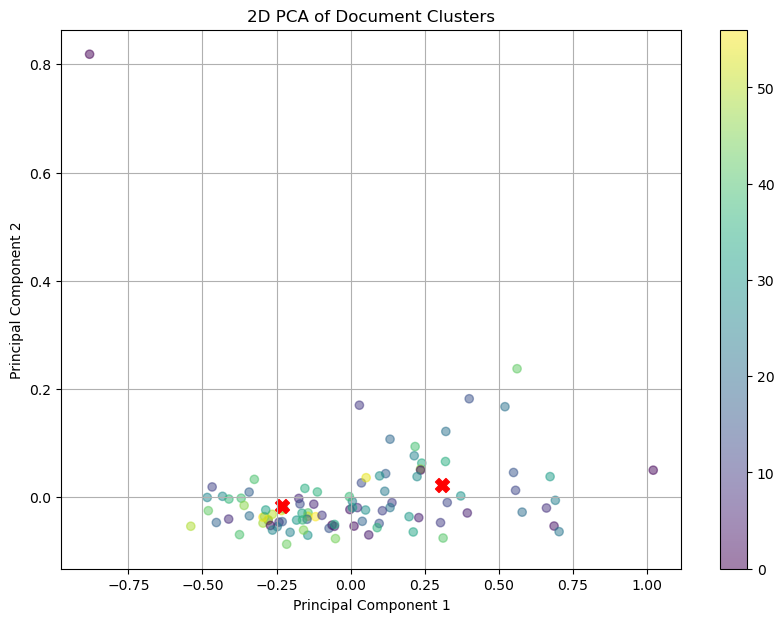

In [6]:
def clustering(D, args=None):
    if args is None:
        args = {}

    # Extract algorithm and maximum number of clusters to evaluate from args:
    algorithm = args.get('algorithm', 'kmeans') # Default algorithm is k-means
    max_k = args.get('max_k', 10) # Default maximum k to evaluate
    vectorizer = args.get('vectorizer', BM25Vectorizer())

    # Prepare document vectors
    document_text = D.apply(lambda x: f"{x['title']} {x['abstract']} {x['authors']} {x['journal']}", axis=1)
    document_vectors = vectorizer.fit_transform(document_text)

    # Determine the best number of clusters (if not provided)
    if 'num_clusters' not in args:
        num_clusters = determine_number_of_clusters(document_vectors, max_k)
    else:
        num_clusters = args['num_clusters']

    # Apply the chosen clustering algorithm
    if algorithm == 'kmeans':
        model = KMeans(n_clusters=num_clusters, random_state=42)
        labels = model.fit_predict(document_vectors)
        centroids = model.cluster_centers_
    else:
        # Add more clustering algorithms as needed
        raise ValueError("Unsupported algorithm")

   # Group document IDs by cluster
    clusters = {i: [] for i in range(num_clusters)}
    for idx, label in enumerate(labels):
        clusters[label].append(D.iloc[idx]['cord_uid'])

    # Generate output
    clustering_solution = []
    for i in range(num_clusters):
        cluster_info = {
            'centroid': centroids[i] if 'centroids' in locals() else None,
            'documents': clusters[i]
        }
        clustering_solution.append(cluster_info)

    return clustering_solution


def plot_clusters_pca(document_vectors, labels, centroids):
    pca = PCA(n_components=2)  # Reduce dimensions to 2 for visualization
    reduced_data = pca.fit_transform(document_vectors)
    reduced_centroids = pca.transform(centroids)

    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, cmap='viridis', marker='o', alpha=0.5)
    
    # Plot centroids
    plt.scatter(reduced_centroids[:, 0], reduced_centroids[:, 1], c='red', marker='X', s=100)
    
    plt.colorbar(scatter)
    plt.title('2D PCA of Document Clusters')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.grid(True)
    plt.show()



# Example usage (with sample size):
sample_size = 100
sample_indices = random.sample(range(len(D)), sample_size)
D_sample = D.iloc[sample_indices]
sample_cluster_result = clustering(D_sample)
print(sample_cluster_result)

# Extract document vectors and labels for visualization
vectorizer = BM25Vectorizer()
document_text = D_sample.apply(lambda x: f"{x['title']} {x['abstract']} {x['authors']} {x['journal']}", axis=1)
document_vectors = vectorizer.fit_transform(document_text)
labels = [label for cluster in sample_cluster_result for label in [cluster['documents'].index(doc_id) for doc_id in cluster['documents']]]

# Assuming centroids are extracted correctly from the clustering function
centroids = np.array([cluster['centroid'] for cluster in sample_cluster_result if 'centroid' in cluster])

# Call the visualization function
plot_clusters_pca(document_vectors, labels, centroids)


*B) Summarization*

In [7]:
def interpret(cluster, D, args=None):
    if args is None:
        args = {}

    # Retrieve document IDs from the cluster
    document_ids = cluster['documents']
    
    # Filter DataFrame for documents in the cluster
    cluster_data = D[D['cord_uid'].isin(document_ids)]

    # Combine the desired fields into a single string for vectorization
    document_texts = cluster_data.apply(lambda x: f"{x['title']} {x['abstract']} {x['authors']} {x['journal']}", axis=1)

    # Prepare document vectors using BM25Vectorizer or any provided vectorizer
    vectorizer = args.get('vectorizer', BM25Vectorizer())
    document_vectors = vectorizer.fit_transform(document_texts)

    # Compute the median vector
    median_vector = np.median(document_vectors, axis=0)
    

    # Compute the medoid
    if len(document_vectors) > 1:
        distance_matrix = euclidean_distances(document_vectors, document_vectors)
        medoid_index = np.argmin(np.sum(distance_matrix, axis=0))
        medoid_document_content = cluster_data.iloc[medoid_index]['title']  # Fetching title or any other identifier
    else:
        medoid_document_content = cluster_data.iloc[0]['title']  # In case there's only one document in the cluster

    # Description based on median and medoid
    description = {
        'median_vector': median_vector,
        'medoid_document_title': medoid_document_content
    }

    return description


# Example ussage: assuming 'D_sample' is a DataFrame version of your document data including 'cord_uid'
for cluster in sample_cluster_result:
    description = interpret(cluster, D_sample)  
    print("Cluster Description:", description)

/Users/amandatofthagen/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Cluster Description: {'median_vector': array([0.08935336, 0.09597492, 0.10728078, 0.10388456, 0.09981993,
       0.08174313, 0.09155003, 0.09367567, 0.09877769, 0.11057597,
       0.11156988, 0.08195976, 0.09880238, 0.11279721, 0.09932237,
       0.08423679, 0.08770128, 0.09826638, 0.09867912, 0.09866906,
       0.10341828, 0.08618302, 0.08463925, 0.08847428, 0.08508196,
       0.08847468, 0.0941681 , 0.10212557, 0.10084352, 0.09393578,
       0.09753946, 0.0874568 , 0.10350743, 0.08517306, 0.        ,
       0.08575115, 0.082155  , 0.09698582, 0.09716003, 0.0942992 ,
       0.08397432, 0.09426518, 0.07520744, 0.09316545, 0.10178901,
       0.08817351, 0.10443611, 0.07454947, 0.10867285, 0.09236551,
       0.09389105, 0.09785901, 0.07622845, 0.09399487, 0.08044642,
       0.09199165, 0.11677024]), 'medoid_document_title': 'Drosophila melanogaster as a model for studying the function of animal viral proteins'}


/Users/amandatofthagen/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Cluster Description: {'median_vector': array([0.09570223, 0.11125069, 0.10918975, 0.10729081, 0.10266922,
       0.1035551 , 0.10697658, 0.11450998, 0.11751794, 0.11726576,
       0.10389253, 0.10259698, 0.11535545, 0.10531336, 0.10772579,
       0.09325149, 0.10679994, 0.11259457, 0.11486337, 0.12935676,
       0.10750518, 0.11546619, 0.1159235 , 0.09581094, 0.10106924,
       0.10463007, 0.11058317, 0.10716857, 0.0952496 , 0.09791896,
       0.10934983, 0.1043071 , 0.10979914, 0.10630759, 0.09694238,
       0.11066308, 0.11722009, 0.11403255, 0.09124009, 0.10861866,
       0.10709558, 0.09704236, 0.12139873]), 'medoid_document_title': 'Influenza A Virus Cell Entry, Replication, Virion Assembly and Movement'}


*D) Evaluation*

In [8]:
def evaluate(D, args):
    if args is None:
        args = {}

    clustering_results = args.get('clustering_results')
    vectorizer = args.get('vectorizer', BM25Vectorizer())
    document_text = D.apply(lambda x: f"{x['title']} {x['abstract']} {x['authors']} {x['journal']}", axis=1)
    document_vectors = vectorizer.fit_transform(document_text)

    # Create a mapping from document IDs to their indices
    doc_id_to_index = {uid: idx for idx, uid in enumerate(D['cord_uid'])}

    # Prepare labels for silhouette score and initialize metrics
    labels = np.empty(len(D), dtype=int)
    sse = 0
    cohesion = 0
    all_distances = euclidean_distances(document_vectors)

    for cluster_index, cluster in enumerate(clustering_results):
        # Convert document IDs to indices using the map
        cluster_doc_indices = [doc_id_to_index[doc_id] for doc_id in cluster['documents'] if doc_id in doc_id_to_index]

        for doc_index in cluster_doc_indices:
            labels[doc_index] = cluster_index
            sse += np.sum((document_vectors[doc_index] - cluster['centroid']) ** 2)
            cohesion += np.sum(all_distances[doc_index][cluster_doc_indices])

    # Calculate separation
    separation = float('inf')
    for i, cluster_a in enumerate(clustering_results):
        for j, cluster_b in enumerate(clustering_results):
            if i != j:
                # Extract all pairwise distances between two clusters
                a_indices = [doc_id_to_index[doc_id] for doc_id in cluster_a['documents'] if doc_id in doc_id_to_index]
                b_indices = [doc_id_to_index[doc_id] for doc_id in cluster_b['documents'] if doc_id in doc_id_to_index]
                inter_cluster_distances = all_distances[a_indices, :][:, b_indices]
                if inter_cluster_distances.size > 0:
                    separation = min(separation, np.min(inter_cluster_distances))

    # Calculate Silhouette Coefficient
    silhouette_avg = silhouette_score(document_vectors, labels)

    evaluation_metrics = {
        'Silhouette Coefficient': silhouette_avg,
        'Sum of Squared Errors (SSE)': sse,
        'Cohesion': cohesion,
        'Separation': separation
    }

    return evaluation_metrics

# Example usage
args = {
    'clustering_results': sample_cluster_result,  # Assume this variable holds your clustering output
    'vectorizer': BM25Vectorizer()
}
evaluate_results = evaluate(D_sample, args)
print(evaluate_results)


/Users/amandatofthagen/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


{'Silhouette Coefficient': 0.2006381553839305, 'Sum of Squared Errors (SSE)': 23.73635484717043, 'Cohesion': 3344.0414468874183, 'Separation': 0.4640519711848429}


<h3>Part II: classification</h3>

*A) Feature extraction*

In [ ]:
#code and statistics here

*B) Classification*

In [ ]:
#code here

*C) Ranking extension*

In [ ]:
#code here

*D) Evaluation*

In [ ]:
#code, statistics and/or charts here

<H2>Question materials (optional)</H2>

<H3>Part I: clustering</H3>

**(1)** Do clustering-guided summarization alters the behavior and efficacy of the IR system?

In [ ]:
#code, statistics and/or charts here

**(2)** How sentence representations, clustering choices, and rank criteria impact summarization?

In [ ]:
#code, statistics and/or charts here

**...** (additional questions with empirical results)

<H3>END</H3>